In [31]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

In [32]:
# Define the model architecture (same as during training)
class SiameseChangeDetectionModel(nn.Module):
    def __init__(self):
        super(SiameseChangeDetectionModel, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 1, kernel_size=1),
            nn.Sigmoid()
        )
        
    def forward(self, x1, x2):
        f1 = self.encoder(x1)
        f2 = self.encoder(x2)
        diff = torch.abs(f1 - f2)
        out = self.decoder(diff)
        return out


In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseChangeDetectionModel().to(device)
model.load_state_dict(torch.load('siamese_change_detection_model.pth'))
model.eval()

/tmp/ipykernel_54215/3166455582.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('siamese_change_detection_model.pth'))


SiameseChangeDetectionModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [34]:
class ChangeDetectionDataset(Dataset):
    def __init__(self, image_dir1, image_dir2, mask_dir=None, transform=None):
        self.image_dir1 = image_dir1
        self.image_dir2 = image_dir2
        self.mask_dir = mask_dir
        self.transform = transform
        self.filenames = os.listdir(self.image_dir1)
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        img1 = Image.open(os.path.join(self.image_dir1, filename)).convert('RGB')
        img2 = Image.open(os.path.join(self.image_dir2, filename)).convert('RGB')
        
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        if self.mask_dir:
            mask = Image.open(os.path.join(self.mask_dir, filename)).convert('L')
            if self.transform:
                mask = self.transform(mask)
                mask = (mask > 0).float()  # Binarize the mask
            return img1, img2, mask
        else:
            return img1, img2

In [35]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])


In [37]:
# Create test dataset and dataloader
test_image_dir1 = '/home/hehe/fyp/dataset/normalized test/current'  # Replace with your actual path
test_image_dir2 = '/home/hehe/fyp/dataset/normalized test/past'     # Replace with your actual path
test_mask_dir = '/home/hehe/fyp/dataset/test/masks'             # Replace with your actual path (if available)

test_dataset = ChangeDetectionDataset(test_image_dir1, test_image_dir2, test_mask_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

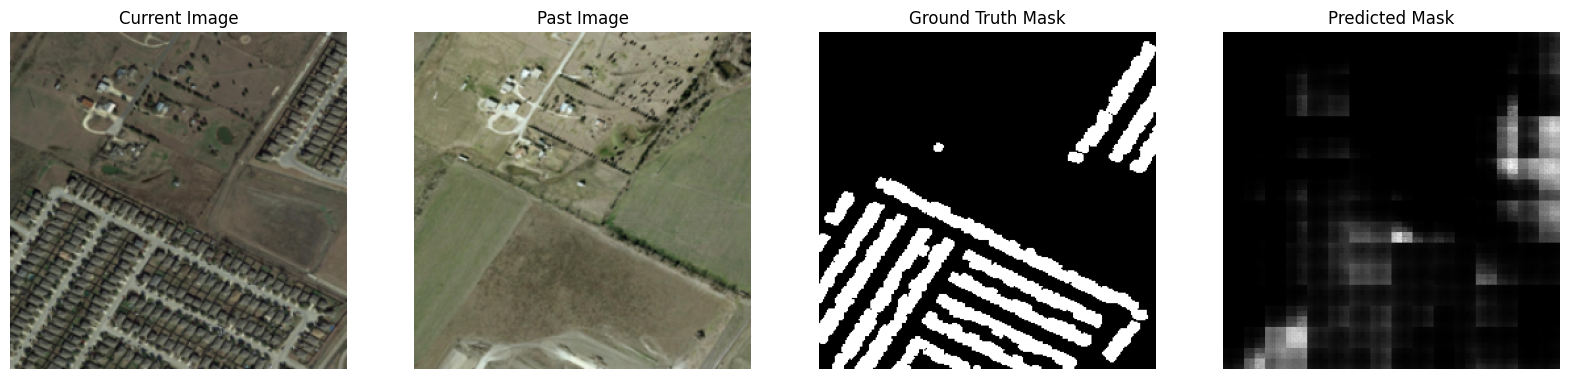

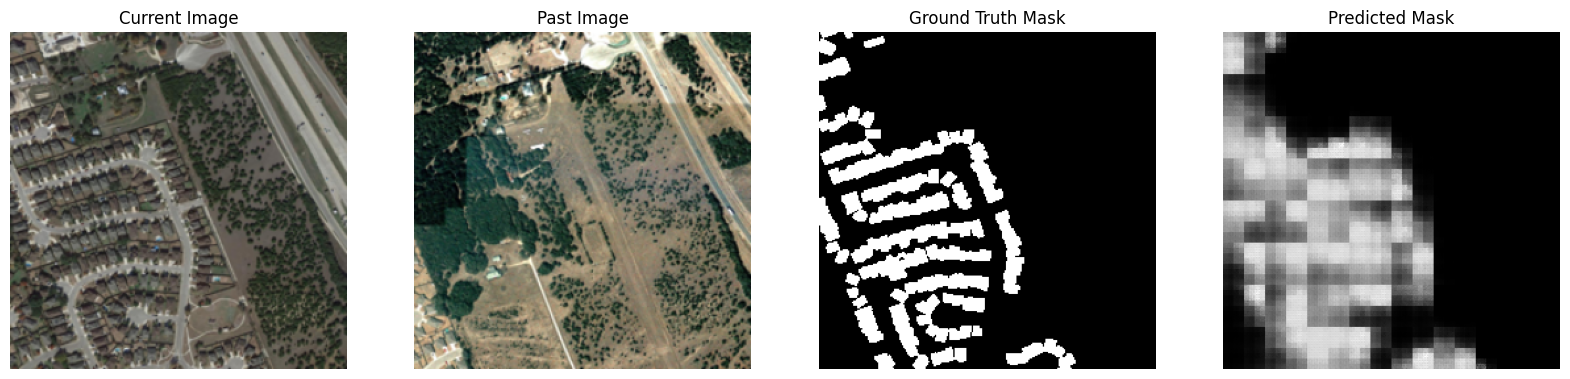

In [ ]:
import matplotlib.pyplot as plt

def visualize(img1, img2, mask, pred):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow(img1.permute(1, 2, 0).cpu().numpy())
    axs[0].set_title('Current Image')
    axs[1].imshow(img2.permute(1, 2, 0).cpu().numpy())
    axs[1].set_title('Past Image')
    axs[2].imshow(mask.squeeze().cpu().numpy(), cmap='gray')
    axs[2].set_title('Ground Truth Mask')
    axs[3].imshow(pred.squeeze().cpu().numpy(), cmap='gray')
    axs[3].set_title('Predicted Mask')
    for ax in axs:
        ax.axis('off')
    plt.show()

model.eval()
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        if test_mask_dir:
            img1, img2, mask = data
            img1, img2, mask = img1.to(device), img2.to(device), mask.to(device)
        else:
            img1, img2 = data
            img1, img2 = img1.to(device), img2.to(device)
        
        output = model(img1, img2)
        
        if test_mask_dir:
            visualize(img1[0], img2[0], mask[0], output[0])
        else:
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(img1[0].permute(1, 2, 0).cpu().numpy())
            plt.title('Current Image')
            plt.axis('off')
            plt.subplot(1, 3, 2)
            plt.imshow(img2[0].permute(1, 2, 0).cpu().numpy())
            plt.title('Past Image')
            plt.axis('off')
            plt.subplot(1, 3, 3)
            plt.imshow(output[0].squeeze().cpu().numpy(), cmap='gray')
            plt.title('Predicted Mask')
            plt.axis('off')
            plt.show()

In [ ]:
def iou(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    if union == 0:
        return float('nan')
    else:
        return intersection / union

model.eval()
ious = []
with torch.no_grad():
    for img1, img2, mask in test_dataloader:
        img1, img2, mask = img1.to(device), img2.to(device), mask.to(device)
        output = model(img1, img2)
        iou_score = iou(output, mask)
        ious.append(iou_score.item())

mean_iou = sum(ious) / len(ious)
print(f'Mean IoU: {mean_iou:.4f}')